this revision should include:
 - nodes randomly waking up and taking part in the process. at first, the resolution of the sim remains : one timeslot.

 find the best values for aMinBE,aMaxBE,RT_max

In [7]:
#!pip install pyswarms
!pip install deap
import numpy as np
import matplotlib.pyplot as plt
from pyswarms.single.global_best import GlobalBestPSO

def simulate(aMaxBE,RT_max,N):
  #all nodes should wake up in the first p timeslots
  p = 10 * N
  sleep_state = np.random.randint(0,p,N)
  #print(sleep_state)
  s = np.min(sleep_state)
  sleep_state = sleep_state - s
  #print(sleep_state)
  aMinBE = 3  # Minimum Backoff Exponent
  #aMaxBE = 5  # Maximum Backoff Exponent
  macMaxCSMABackoffs = 5  # Maximum CSMA backoffs
  packet = 13 #packet length in time-slots
  #RT_max = 4
  ACK = 1 #12 SYMBOLS TURNAROUND TIME + ack
  MaxAckWait = 3 #timeslots - typically 54
  NB = np.zeros(N, dtype=int)  # Number of backoffs
  BE = np.full(N, aMinBE, dtype=int)  # Backoff exponent
  delay = np.random.randint(0, 2**aMinBE, N)  # Delay values
  tx_packet = np.zeros(N, dtype=int)  # Time remaining in busy state for each node
  RT = np.zeros(N,dtype=int)
  channel_busy = 0 #timeslot left for busy channel
  #Tracking variables
  nbTx= np.zeros(N, dtype=int)
  nbCol = np.zeros(N, dtype=int)
  nbFail = np.zeros(N, dtype=int)
  nbBackoff = np.zeros(N,dtype = int)
  nbCCA = np.zeros(N, dtype=int)
  nbRx = np.zeros(N,dtype = int)
  delay_n = delay
  waitAck = np.zeros(N,dtype=int)
  k=0


  while np.any(delay > -10): #while there are still nodes with packets
      #assign delay = -9 to nodes who are still sleeping
      #print(f"sleep state is {sleep_state}")
      delay_n = np.where(sleep_state!=0,-9,delay_n)
      delay = delay_n
      op = np.where((waitAck>0) & (delay>-10))
      waitAck[op] -=1
      if (np.any(waitAck[op]==0)):
        #resetCounters
        delay_n[op] = np.random.randint(0, 2**aMinBE, op[0].size)  # Delay value
      if channel_busy>0:
        channel_busy -=1
        if channel_busy==0:
          h = np.where(delay==-3)
          waitAck[h] = MaxAckWait
      #print(f"Currently simulating slot {k}:")
      #check to see if any node is ready for CCA
      #print(f"Channel is Busy for {channel_busy} more time-slots")
      #print(f"Backoff Counter at the start of {k} slot is {delay}")
      #print("Wait Ack" + str(waitAck))
      bo = np.where(delay>-1) #nodes either in backoff or cca
      nbBackoff[bo]+=1
      delay_n[bo] = delay_n[bo] -1 #decrement counter
      arg_cca = np.where(delay == -1) #nodes that just did cca
      nbCCA[arg_cca] += 1 #keep track of number of cca performed
      if channel_busy == 0:
        cca_no = arg_cca[0].size
        if cca_no > 1:
          #case of collision
          delay_n[arg_cca] = -3 #tx_col
          channel_busy = packet + 1
          #update metrics
          nbCol[arg_cca] +=1
          #update RT
          RT[arg_cca] +=1
          #print("RT IS " + str(RT))
          NB[arg_cca] = 0 #reset
          ux = np.where((RT>RT_max) & (delay>-50))
          delay_n[ux] = -200 #failed due to reaching the max levels of retries
        elif cca_no == 1:
          delay_n[arg_cca] = -2 #tx_col
          channel_busy = packet + ACK +1
          nbTx[arg_cca] +=1
          delay_n[arg_cca] = -100 #succesfull transmission
      else:
        NB[arg_cca] +=1
        if arg_cca[0].size>0:  # This checks if arg_cca is not empty
          for i in arg_cca[0]:
            BE[i] = np.min(np.array([BE[i] + 1, aMaxBE]))
            #print(f"BE is {BE}")
        delay_n[arg_cca] = np.array([np.random.randint(1, 2**BE[i]) for i in arg_cca])  # Delay value
        f = np.where(NB>macMaxCSMABackoffs)
        delay_n[f] = -200 #failed to transmit due to reaching max value of BackOffs
      s_wu = np.where(sleep_state == 1)
      #print(f"s_wu is {s_wu} and s_wu size is {s_wu[0].size} ")
      #print(f"delay n[wu]  shape is {delay_n[s_wu[0]].shape}")
      delay_n[s_wu] = np.random.randint(0,2**aMinBE,s_wu[0].size)
      sleep_state = np.where(sleep_state != 0, sleep_state - 1, sleep_state)
      k += 1
      #print("NB status is " + str(NB))
      #print(" ")
  transmissions = (delay == -100).sum()
  throughput = np.sum(transmissions*packet)/k
  col = (nbCol == 1).sum()
  bo_mean = np.mean(nbBackoff)
  cca_mean = np.mean(nbCCA)
  return np.array([throughput,col,transmissions,bo_mean,cca_mean])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.4 MB/s eta 0:00:00m eta 0:00:010:01:01
  Preparing metadata (setup.py) ... done
  Created wheel for deap: filename=deap-1.4.1-cp311-cp311-linux_x86_64.whl size=105694 sha256=612c2c068761bc7221e6e5652e73d7c1ab59bf30e1dec6c7d82a17539fafc7c7
  Stored in directory: /home/alexandros/.cache/pip/wheels/f8/64/b8/65eacfbff3024ae2e2beb22e691d5c8abb89fbd863b8049b5f
Successfully built deap

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from deap import base, creator, tools, algorithms
from functools import partial
def evaluate(individual, c):
    a, b = individual
    d_mean, f_mean = np.zeros(20), np.zeros(20)
    
    for j in range(20):
        d, e, f, g, h = simulate(a, b, c)
        d_mean[j] = d
        f_mean[j] = f

    d_value = np.mean(d_mean)
    f_value = np.mean(f_mean)
    
    if f_value < 0.99*c:
        return 1000,  # Penalize heavily for invalid f
    else:
        return 1 / d_value,  # Minimize reciprocal

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 4, 11)  # Integer [4, 10] for a
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[4, 2], up=[10, 10], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Optimization loop
c = 5
results = []

while c < 51:
    # Use functools.partial to pass 'c' to evaluate
    toolbox.register("evaluate", partial(evaluate, c=c))
    
    pop = toolbox.population(n=70)
    hof = tools.HallOfFame(1)
    
    algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=30, halloffame=hof, verbose=True)
    
    best_ind = hof[0]
    print(f"c={c}, Best individual: {best_ind}, Fitness: {best_ind.fitness.values[0]}")
    results.append((c, best_ind, best_ind.fitness.values[0]))
    c += 5

print("Final Results:", results)

In [2]:
import pyswarms as ps
import numpy as np

pos = []
cos = []
no = []
c = 5

while (c<51):

    def objective_function(params):
        a = np.rint(params[:, 0]).astype(int)
        b = np.rint(params[:, 1]).astype(int)

    # Initialize arrays for d and e
        d_values = np.zeros(len(a))
        f_values = np.zeros(len(a))
        cost = np.zeros(len(a))
        d_mean = np.zeros(20)
        f_mean = np.zeros(20)

    # Compute d and e for each pair of a, b values
        for i in range(len(a)):
          for j in range(0,20):
            d, e ,f,g,h= simulate(a[i], b[i], c)
            d_mean[j] = d
            f_mean[j] = f
          d_values[i] = np.mean(d_mean)
          f_values[i] = np.mean(f_mean)
          if f_values[i] <9.9:
            cost[i] = 100
          else:
            cost[i] = 1/d_values[i]

        return cost

# Define hyperparameters for the PSO algorithm
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Bounds for a and b (2D search space)
    bounds = (np.array([4, 2]), np.array([10, 10]))  # Define appropriate bounds

# Initialize optimizer
    optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# Perform optimization
    best_cost, best_pos = optimizer.optimize(objective_function, iters=20)

    print("Best parameters (a, b):", best_pos)
    print("Best objective value:", best_cost)
    print(f'{c} is c')
    pos.append(best_pos)
    cos.append(best_cost)
    no.append(c)
    c+=5

2024-11-17 17:58:19,536 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████████████████████|20/20, best_cost=100
2024-11-17 17:58:45,728 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 100.0, best pos: [9.12591844 3.94434753]
2024-11-17 17:58:45,736 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Best parameters (a, b): [9.12591844 3.94434753]
Best objective value: 100.0
5 is c


pyswarms.single.global_best: 100%|████████████████████████|20/20, best_cost=1.86
2024-11-17 17:59:42,728 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.8594620050346589, best pos: [6.80001986 6.50095023]
2024-11-17 17:59:42,735 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Best parameters (a, b): [6.80001986 6.50095023]
Best objective value: 1.8594620050346589
10 is c


pyswarms.single.global_best: 100%|████████████████████████|20/20, best_cost=1.39
2024-11-17 18:00:52,267 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.38716372578868, best pos: [5.47904025 6.45079967]
2024-11-17 18:00:52,273 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Best parameters (a, b): [5.47904025 6.45079967]
Best objective value: 1.38716372578868
15 is c


pyswarms.single.global_best: 100%|████████████████████████|20/20, best_cost=1.46
2024-11-17 18:02:27,345 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.4564868087203562, best pos: [5.16872313 4.35587825]
2024-11-17 18:02:27,350 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Best parameters (a, b): [5.16872313 4.35587825]
Best objective value: 1.4564868087203562
20 is c


pyswarms.single.global_best: 100%|████████████████████████|20/20, best_cost=1.53
2024-11-17 18:04:09,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.5304987288443617, best pos: [5.00845723 6.6027138 ]
2024-11-17 18:04:09,752 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Best parameters (a, b): [5.00845723 6.6027138 ]
Best objective value: 1.5304987288443617
25 is c


pyswarms.single.global_best: 100%|█████████████████████████|20/20, best_cost=1.5
2024-11-17 18:06:04,428 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.5002283307900866, best pos: [5.34673511 8.05552559]
2024-11-17 18:06:04,442 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Best parameters (a, b): [5.34673511 8.05552559]
Best objective value: 1.5002283307900866
30 is c


pyswarms.single.global_best: 100%|████████████████████████|20/20, best_cost=1.61
2024-11-17 18:08:17,118 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.6072796998502117, best pos: [6.07388851 6.92494639]
2024-11-17 18:08:17,125 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Best parameters (a, b): [6.07388851 6.92494639]
Best objective value: 1.6072796998502117
35 is c


pyswarms.single.global_best: 100%|████████████████████████|20/20, best_cost=1.72
2024-11-17 18:10:18,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.7151665393532431, best pos: [4.79834174 9.07178314]
2024-11-17 18:10:18,220 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Best parameters (a, b): [4.79834174 9.07178314]
Best objective value: 1.7151665393532431
40 is c


pyswarms.single.global_best: 100%|████████████████████████|20/20, best_cost=1.77
2024-11-17 18:12:30,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.769863910858959, best pos: [7.20078327 7.82046406]
2024-11-17 18:12:30,783 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Best parameters (a, b): [7.20078327 7.82046406]
Best objective value: 1.769863910858959
45 is c


pyswarms.single.global_best: 100%|████████████████████████|20/20, best_cost=1.79
2024-11-17 18:14:57,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.792953735789098, best pos: [6.07915677 5.43603974]


Best parameters (a, b): [6.07915677 5.43603974]
Best objective value: 1.792953735789098
50 is c


In [3]:
np.savez('multiple_arrays', cost=np.array(cos), pos=np.array(pos), no=np.array(no))

NameError: name 'cos' is not defined

In [14]:
u = np.load('pos.npy') #minBE
u

array([[4.34117983, 2.14331439],
       [8.29337169, 8.36786123],
       [4.11953388, 4.57234884],
       [4.37999019, 5.5080709 ],
       [4.07595292, 7.53799423],
       [4.29206672, 6.01517152],
       [4.78855225, 5.90031068],
       [4.81856265, 2.82166082],
       [4.84586555, 9.81100811],
       [5.06145859, 4.52285541]])

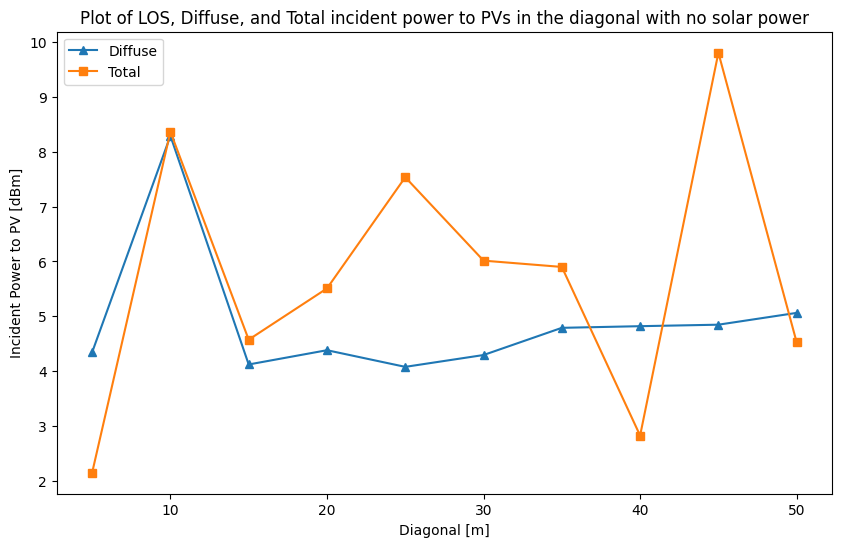

In [15]:
thr_i = 1/np.load('cost.npy')
no = np.load('no.npy')
k = np.load('pos.npy')[:,0] #minBE
r = np.load('pos.npy')[:,1] #MAXRT

plt.figure(figsize=(10, 6))
#plt.plot(no, thr_i, marker='o',label='LOS')
plt.plot(no,k,marker='^', label='Diffuse')
plt.plot(no, r, marker='s',label='Total')
plt.xlabel("Diagonal [m]")
plt.ylabel("Incident Power to PV [dBm]")
plt.title("Plot of LOS, Diffuse, and Total incident power to PVs in the diagonal with no solar power")
plt.legend()
plt.show()

In [ ]:
nodes = np.linspace(5,50,10,dtype=int)
thr = np.zeros(nodes.shape)
col = np.zeros(nodes.shape)
tx = np.zeros(nodes.shape)
bo = np.zeros(nodes.shape)
cca = np.zeros(nodes.shape)
i=0
for n in nodes:
  thr_h = np.zeros((5000,))
  col_h = np.zeros((5000,))
  tx_h = np.zeros((5000,))
  bo_h = np.zeros((5000,))
  cca_h = np.zeros((5000,))
  for j in range(0,5000):
    var = simulate(n)
    #print(var[1])
    thr_h[j] = var[0]
    col_h[j] = var[1]
    tx_h[j] = var[2]
    bo_h[j] = var[3]
    cca_h[j] = var[4]
    print(f'j is {j}')
  #print(thr_h)
  thr[i] = np.mean(thr_h)
  col[i] = np.mean(col_h)
  tx[i] = np.mean(tx_h)
  bo[i] = np.mean(bo_h)
  cca[i] = np.mean(cca_h)
  print(f'i is {i}')
  i+=1

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
j is 20
j is 21
j is 22
j is 23
j is 24
j is 25
j is 26
j is 27
j is 28
j is 29
j is 30
j is 31
j is 32
j is 33
j is 34
j is 35
j is 36
j is 37
j is 38
j is 39
j is 40
j is 41
j is 42
j is 43
j is 44
j is 45
j is 46
j is 47
j is 48
j is 49
j is 50
j is 51
j is 52
j is 53
j is 54
j is 55
j is 56
j is 57
j is 58
j is 59
j is 60
j is 61
j is 62
j is 63
j is 64
j is 65
j is 66
j is 67
j is 68
j is 69
j is 70
j is 71
j is 72
j is 73
j is 74
j is 75
j is 76
j is 77
j is 78
j is 79
j is 80
j is 81
j is 82
j is 83
j is 84
j is 85
j is 86
j is 87
j is 88
j is 89
j is 90
j is 91
j is 92
j is 93
j is 94
j is 95
j is 96
j is 97
j is 98
j is 99
j is 100
j is 101
j is 102
j is 103
j is 104
j is 105
j is 106
j is 107
j is 108
j is 109
j is 110
j is 111
j is 112
j is 113
j is 114
j is 115
j is 116
j is 117


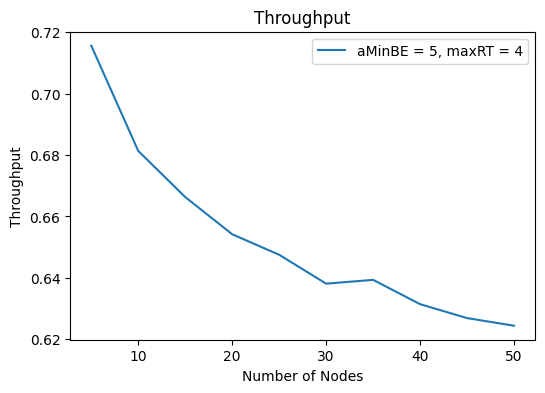

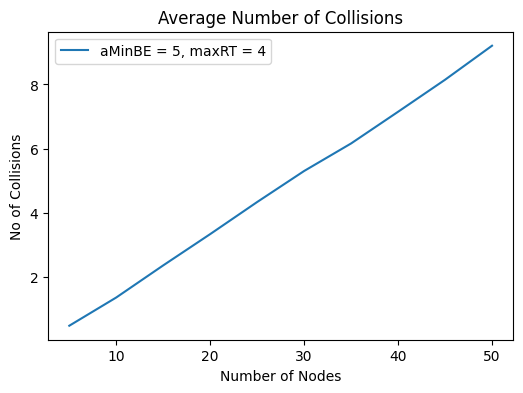

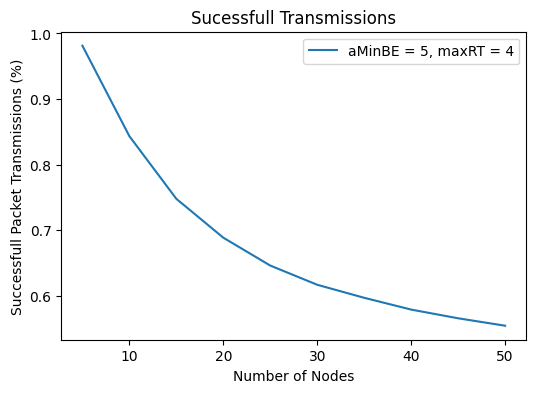

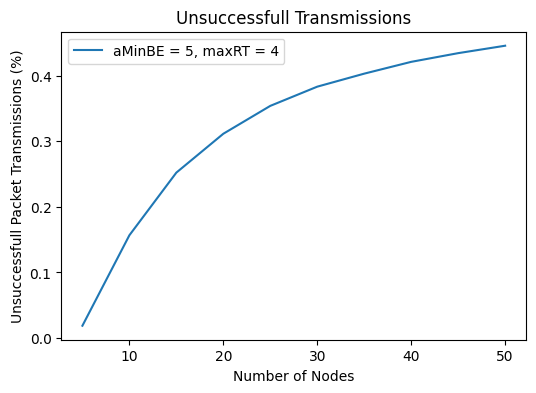

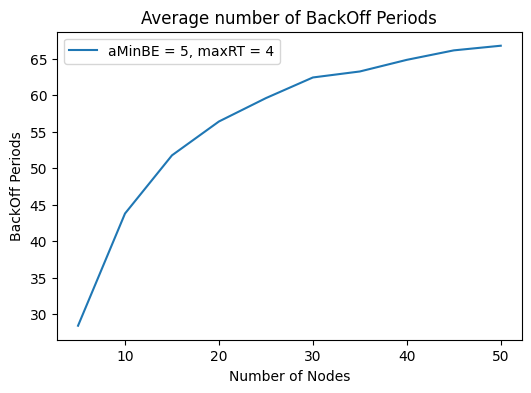

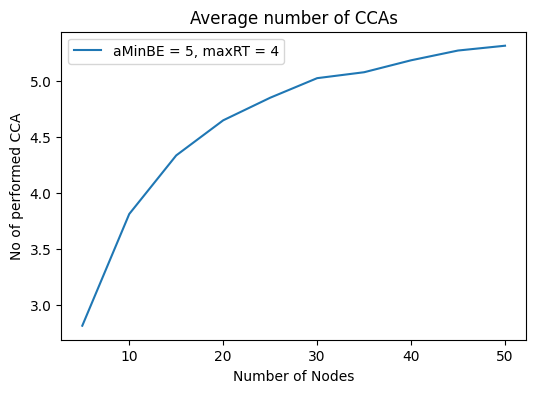

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_data = [thr, col, tx/nodes, (nodes-tx)/nodes, bo, cca]
np.savez('csma.ca.unslotted.var.sleep', thr=thr, col=col, tx=tx/nodes, f_tx=(nodes-tx)/nodes, bo=bo, cca=cca)
titles = ["Throughput", "Average Number of Collisions", "Sucessfull Transmissions", "Unsuccessfull Transmissions", "Average number of BackOff Periods", "Average number of CCAs"]
y_labels = ["Throughput", "No of Collisions", "Successfull Packet Transmissions (%)", "Unsuccessfull Packet Transmissions (%)", "BackOff Periods", "No of performed CCA"]

for i, y in enumerate(y_data):
    plt.figure(figsize=(6, 4))
    plt.plot(nodes, y, label=f"aMinBE = 5, maxRT = 4")
    plt.title(titles[i])
    plt.xlabel("Number of Nodes")
    plt.ylabel(y_labels[i])
    plt.legend()  # Add the legend to each plot
    plt.show()


In [ ]:
#calculate energy consumption based on simulation results/ start with N = 5
N = nodes[0]
backoffs = bo[0]
collisions = col[0]
tx_all = tx[0]
cca_m = cca[0]
packet = 13

#calculate time in seconds for bo periods
bo_time = backoffs * t_slot
#calculate time spent on cca
cca_time = cca_m * t_slot * (6/20) #cca duration (6 symbols) - (14 symbols cpu on)
#total cpu on - radio off time
cca_time = cca_m * t_slot * (14/20) + bo_time + (collisions/N)* t_slot*(12/20) + (tx_all/N)*t_slot*(12/20) #turnaround_time
#total receiving time
w4ack = (collisions/N)*54*t_symbol #due to collisions
wack = (tx_all/N)*8*t_symbol #successful
#total transmitting time
w4rx = (collisions/N) * t_slot * packet + (tx_all/N)*t_slot*packet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def simulate(N,packet):
  #all nodes should wake up in the first p timeslots
  p = 10*N
  sleep_state = np.random.randint(0,p,N)
  print(sleep_state)
  s = np.min(sleep_state)
  sleep_state = sleep_state - s
  print(sleep_state)
  aMinBE = 3  # Minimum Backoff Exponent
  aMaxBE = 5  # Maximum Backoff Exponent
  macMaxCSMABackoffs = 5  # Maximum CSMA backoffs
  #packet = 13 #packet length in time-slots
  RT_max = 4
  ACK = 1 #12 SYMBOLS TURNAROUND TIME + ack
  MaxAckWait = 3 #timeslots - typically 54
  NB = np.zeros(N, dtype=int)  # Number of backoffs
  BE = np.full(N, aMinBE, dtype=int)  # Backoff exponent
  delay = np.random.randint(0, 2**aMinBE, N)  # Delay values
  tx_packet = np.zeros(N, dtype=int)  # Time remaining in busy state for each node
  RT = np.zeros(N,dtype=int)
  channel_busy = 0 #timeslot left for busy channel
  #Tracking variables
  nbTx= np.zeros(N, dtype=int)
  nbCol = np.zeros(N, dtype=int)
  nbFail = np.zeros(N, dtype=int)
  nbBackoff = np.zeros(N,dtype = int)
  nbCCA = np.zeros(N, dtype=int)
  nbRx = np.zeros(N,dtype = int)
  delay_n = delay
  waitAck = np.zeros(N,dtype=int)
  k=0


  while np.any(delay > -10): #while there are still nodes with packets
      #assign delay = -9 to nodes who are still sleeping
      print(f"sleep state is {sleep_state}")
      delay_n = np.where(sleep_state!=0,-9,delay_n)
      delay = delay_n
      op = np.where((waitAck>0) & (delay>-10))
      waitAck[op] -=1
      if (np.any(waitAck[op]==0)):
        #resetCounters
        delay_n[op] = np.random.randint(0, 2**aMinBE, op[0].size)  # Delay value
      if channel_busy>0:
        channel_busy -=1
        if channel_busy==0:
          h = np.where(delay==-3)
          waitAck[h] = MaxAckWait
      print(f"Currently simulating slot {k}:")
      #check to see if any node is ready for CCA
      print(f"Channel is Busy for {channel_busy} more time-slots")
      print(f"Backoff Counter at the start of {k} slot is {delay}")
      print("Wait Ack" + str(waitAck))
      bo = np.where(delay>-1) #nodes either in backoff or cca
      nbBackoff[bo]+=1
      delay_n[bo] = delay_n[bo] -1 #decrement counter
      arg_cca = np.where(delay == -1) #nodes that just did cca
      nbCCA[arg_cca] += 1 #keep track of number of cca performed
      if channel_busy == 0:
        cca_no = arg_cca[0].size
        if cca_no > 1:
          #case of collision
          delay_n[arg_cca] = -3 #tx_col
          channel_busy = packet + 1
          #update metrics
          nbCol[arg_cca] +=1
          #update RT
          RT[arg_cca] +=1
          print("RT IS " + str(RT))
          NB[arg_cca] = 0 #reset
          ux = np.where((RT>RT_max) & (delay>-50))
          delay_n[ux] = -200 #failed due to reaching the max levels of retries
        elif cca_no == 1:
          delay_n[arg_cca] = -2 #tx_col
          channel_busy = packet + ACK +1
          nbTx[arg_cca] +=1
          delay_n[arg_cca] = -100 #succesfull transmission
      else:
        NB[arg_cca] +=1
        if arg_cca[0].size>0:  # This checks if arg_cca is not empty
          for i in arg_cca[0]:
            BE[i] = np.min(np.array([BE[i] + 1, aMaxBE]))
            print(f"BE is {BE}")
        delay_n[arg_cca] = np.array([np.random.randint(1, 2**BE[i]) for i in arg_cca])  # Delay value
        f = np.where(NB>macMaxCSMABackoffs)
        delay_n[f] = -200 #failed to transmit due to reaching max value of BackOffs
      s_wu = np.where(sleep_state == 1)
      delay_n[s_wu] = np.random.randint(0,2**aMinBE,s_wu[0].size)
      sleep_state = np.where(sleep_state != 0, sleep_state - 1, sleep_state)
      k += 1
      print("NB status is " + str(NB))
      print(" ")
  transmissions = (delay == -100).sum()
  throughput = np.sum(transmissions*packet)/k
  col = (nbCol == 1).sum()
  bo_mean = np.mean(nbBackoff)
  cca_mean = np.mean(nbCCA)
  return np.array([throughput,col,transmissions,bo_mean,cca_mean])

In [ ]:
thr_h = np.zeros((2000,))
col_h = np.zeros((2000,))
tx_h = np.zeros((2000,))
bo_h = np.zeros((2000,))
cca_h = np.zeros((2000,))
for j in range(0,2000):
  var = simulate(10,2)
  #print(var[1])
  thr_h[j] = var[0]
  col_h[j] = var[1]
  tx_h[j] = var[2]
  bo_h[j] = var[3]
  cca_h[j] = var[4]
  #print(thr_h)
thr = np.mean(thr_h)
col = np.mean(col_h)
tx = np.mean(tx_h)
bo = np.mean(bo_h)
cca  = np.mean(cca_h)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Currently simulating slot 62:
Channel is Busy for 0 more time-slots
Backoff Counter at the start of 62 slot is [-100 -100 -100 -100   -9   -3 -100   -3    9   -9]
Wait Ack[0 0 0 0 0 3 0 3 0 0]
NB status is [0 1 0 0 0 0 0 0 1 0]
 
sleep state is [ 0  0  0  0 15  0  0  0  0  8]
Currently simulating slot 63:
Channel is Busy for 0 more time-slots
Backoff Counter at the start of 63 slot is [-100 -100 -100 -100   -9   -3 -100   -3    8   -9]
Wait Ack[0 0 0 0 0 2 0 2 0 0]
NB status is [0 1 0 0 0 0 0 0 1 0]
 
sleep state is [ 0  0  0  0 14  0  0  0  0  7]
Currently simulating slot 64:
Channel is Busy for 0 more time-slots
Backoff Counter at the start of 64 slot is [-100 -100 -100 -100   -9   -3 -100   -3    7   -9]
Wait Ack[0 0 0 0 0 1 0 1 0 0]
NB status is [0 1 0 0 0 0 0 0 1 0]
 
sleep state is [ 0  0  0  0 13  0  0  0  0  6]
Currently simulating slot 65:
Channel is Busy for 0 more time-slots
Backoff Counter at the start of 65 slot is [-1

In [ ]:
print(thr)
print(tx)
print(cca)
print(bo)
print(col)

0.20897229493770844
9.9975
1.5641999999999998
9.887
0.9055


In [ ]:
data_rate = 250e3 #bps
t_symbol = (1/data_rate) * 4
t_slot = 20 * t_symbol
t_slot
N = 10
packet = 2 #20 byte
#calculate time in seconds for bo periods
bo_time = bo * t_slot
#calculate time spent on cca
cca_time = cca* t_slot * (6/20) #cca duration (6 symbols) - (14 symbols cpu on)
#total cpu on - radio off time
cca_time = cca * t_slot * (14/20) + bo_time + (col/N)* t_slot*(12/20) + (tx/N)*t_slot*(12/20) #backoff periods + turnaround_time (for succesfull and unsuccessful)
#total receiving time
w4ack = (col/N)*54*t_symbol #due to collisions
wack = (tx/N)*8*t_symbol #successful
#total transmitting time
w4rx = (col/N) * t_slot * packet + (tx/N)*t_slot*packet